# Lunar Lander with Reinforcement Learning

This notebook demonstrates reinforcement learning using the classic Lunar Lander environment from OpenAI Gym. We'll implement and compare different RL algorithms to train an agent to successfully land a spacecraft.

## Learning Objectives
- Understand the Lunar Lander environment
- Implement Deep Q-Network (DQN) algorithm
- Train an agent to land successfully
- Visualize training progress and performance
- Compare different approaches and hyperparameters

## Environment Description
The Lunar Lander environment simulates landing a spacecraft on the moon. The agent must control the lander's engines to achieve a safe landing while minimizing fuel consumption.

**State Space**: 8 continuous values representing position, velocity, angle, and contact sensors
**Action Space**: 4 discrete actions (do nothing, fire left engine, fire main engine, fire right engine)
**Reward**: +100 for landing safely, -100 for crashing, fuel penalty for engine use

## 1. Environment Setup and Installation

In [1]:
# Install required packages
import subprocess
import sys
import importlib

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        print(f"✓ {package} installed successfully")
        return True
    except subprocess.CalledProcessError as e:
        print(f"✗ Failed to install {package}: {e}")
        return False

def check_package(package_name, import_name=None):
    """Check if a package is installed"""
    if import_name is None:
        import_name = package_name
    try:
        importlib.import_module(import_name)
        return True
    except ImportError:
        return False

# Define packages to install
packages = [
    ('gymnasium', 'gymnasium'),
    ('Box2D', 'Box2D'),
    ('torch', 'torch'), 
    ('numpy', 'numpy'),
    ('matplotlib', 'matplotlib'),
    ('seaborn', 'seaborn'),
    ('tqdm', 'tqdm'),
    ('opencv-python', 'cv2')
]

print("Checking and installing required packages...\n")

for package, import_name in packages:
    if check_package(import_name):
        print(f"✓ {package} is already installed")
    else:
        print(f"Installing {package}...")
        if package == 'opencv-python':
            install_package('opencv-python-headless')  # Use headless version for notebooks
        else:
            install_package(package)

print(f"\n🎉 Package installation complete!")
print(f"If you still encounter issues with Box2D, try running:")
print(f"pip install 'gymnasium[box2d]' in your terminal")

Checking and installing required packages...

✓ gymnasium is already installed
✓ Box2D is already installed
✓ torch is already installed
✓ numpy is already installed
✓ matplotlib is already installed
✓ seaborn is already installed
✓ tqdm is already installed
✓ opencv-python is already installed

🎉 Package installation complete!
If you still encounter issues with Box2D, try running:
pip install 'gymnasium[box2d]' in your terminal


In [2]:
# Import required libraries
try:
    import gymnasium as gym
    print("✓ Gymnasium imported successfully")
except ImportError as e:
    print(f"❌ Error importing gymnasium: {e}")
    raise

try:
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import random
    from collections import deque, namedtuple
    from tqdm import tqdm
    from IPython.display import HTML, display
    import base64
    import io
    print("✓ Basic packages imported successfully")
except ImportError as e:
    print(f"❌ Error importing basic packages: {e}")
    raise

# Try importing PyTorch (optional for Q-learning version)
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    print("✓ PyTorch imported successfully")
    TORCH_AVAILABLE = True
except ImportError:
    print("⚠️ PyTorch not available - some advanced features will be disabled")
    TORCH_AVAILABLE = False

# Try importing OpenCV (optional)
try:
    import cv2
    print("✓ OpenCV imported successfully")
    CV2_AVAILABLE = True
except ImportError:
    print("⚠️ OpenCV not available - some visualization features may be limited")
    CV2_AVAILABLE = False

# Set random seeds for reproducibility
np.random.seed(42)
if TORCH_AVAILABLE:
    torch.manual_seed(42)
random.seed(42)

# Configure matplotlib
plt.style.use('default')  # Use default instead of seaborn-v0_8 to avoid version issues
plt.rcParams['figure.figsize'] = (12, 8)

print(f"\n🎉 Libraries imported successfully!")
if TORCH_AVAILABLE:
    print(f"PyTorch version: {torch.__version__}")
print(f"Gymnasium version: {gym.__version__}")
print(f"NumPy version: {np.__version__}")


print(f"\n💡 Ready to proceed with reinforcement learning!")

✓ Gymnasium imported successfully
✓ Basic packages imported successfully
✓ PyTorch imported successfully
✓ OpenCV imported successfully

🎉 Libraries imported successfully!
PyTorch version: 2.4.1+cpu
Gymnasium version: 1.2.0
NumPy version: 1.26.4

💡 Ready to proceed with reinforcement learning!


## 2. Exploring the Lunar Lander Environment

In [3]:
# Create and explore the environment
try:
    env = gym.make('LunarLander-v3', render_mode='rgb_array')
    print("✓ LunarLander environment created successfully!")
except Exception as e:
    print(f"❌ Error creating environment: {e}")
    print("\nTrying to install missing dependencies...")
    import subprocess
    import sys
    
    try:
        # Install Box2D dependencies
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'Box2D'])
        print("✓ Box2D installed successfully!")
        
        # Try creating environment again
        env = gym.make('LunarLander-v3', render_mode='rgb_array')
        print("✓ LunarLander environment created successfully after installing dependencies!")
    except Exception as install_error:
        print(f"❌ Failed to install dependencies: {install_error}")
        print("Please run: pip install 'gymnasium[box2d]' in your terminal")
        raise

print("=== Lunar Lander Environment Information ===")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Number of actions: {env.action_space.n}")

# Action meanings
action_meanings = {
    0: "Do nothing",
    1: "Fire left orientation engine",
    2: "Fire main engine",
    3: "Fire right orientation engine"
}

print("\n=== Action Space ===")
for action, meaning in action_meanings.items():
    print(f"Action {action}: {meaning}")

# Observation space description
obs_descriptions = [
    "Horizontal coordinate",
    "Vertical coordinate", 
    "Horizontal velocity",
    "Vertical velocity",
    "Angle",
    "Angular velocity",
    "Left leg contact (boolean)",
    "Right leg contact (boolean)"
]

print("\n=== Observation Space ===")
for i, desc in enumerate(obs_descriptions):
    print(f"Index {i}: {desc}")

✓ LunarLander environment created successfully!
=== Lunar Lander Environment Information ===
Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Number of actions: 4

=== Action Space ===
Action 0: Do nothing
Action 1: Fire left orientation engine
Action 2: Fire main engine
Action 3: Fire right orientation engine

=== Observation Space ===
Index 0: Horizontal coordinate
Index 1: Vertical coordinate
Index 2: Horizontal velocity
Index 3: Vertical velocity
Index 4: Angle
Index 5: Angular velocity
Index 6: Left leg contact (boolean)
Index 7: Right leg contact (boolean)


Running random episode...
Episode ended after 74 steps
Total reward: 24.89
Final observation: [-0.12008877 -0.02002247 -0.02440151 -0.20859508  0.2987257  -1.5589452
  0.          1.        ]


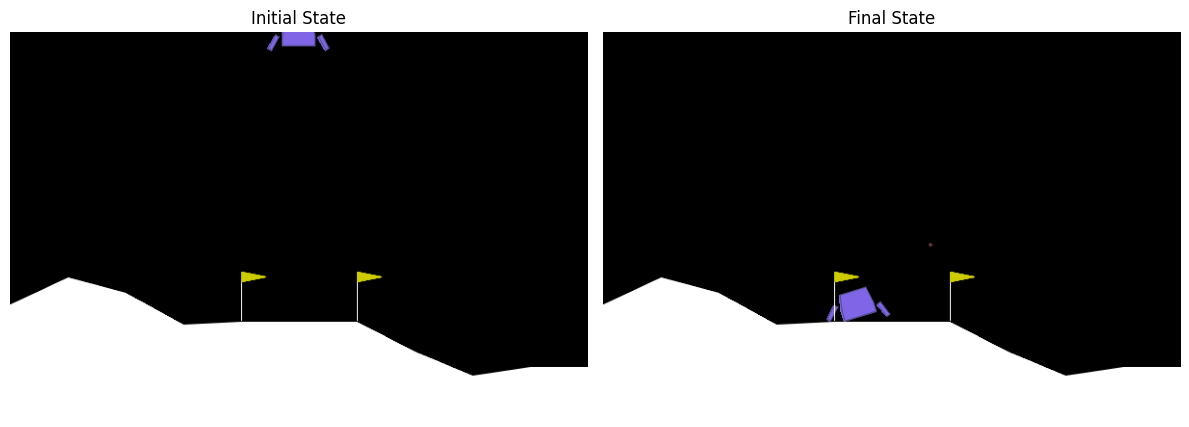

In [4]:
# Visualize a random episode
def visualize_random_episode(env, max_steps=500):
    """Visualize a random episode to understand the environment"""
    
    observation, _ = env.reset()
    frames = []
    total_reward = 0
    
    print("Running random episode...")
    
    for step in range(max_steps):
        # Take random action
        action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        
        # Capture frame
        frame = env.render()
        frames.append(frame)
        
        total_reward += reward
        
        if terminated or truncated:
            print(f"Episode ended after {step + 1} steps")
            print(f"Total reward: {total_reward:.2f}")
            print(f"Final observation: {observation}")
            break
    
    # Show first and last frames
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    
    ax1.imshow(frames[0])
    ax1.set_title("Initial State")
    ax1.axis('off')
    
    ax2.imshow(frames[-1])
    ax2.set_title("Final State")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return frames

# Run visualization
frames = visualize_random_episode(env)

## 3. Deep Q-Network (DQN) Implementation

Now we'll implement a Deep Q-Network to learn how to land the lunar lander. DQN uses a neural network to approximate the Q-function, which estimates the expected future reward for each action in a given state.

In [5]:
# Experience replay buffer
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    """Experience replay buffer for DQN"""
    
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        """Sample random batch of experiences"""
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

print("Experience replay buffer implemented!")

Experience replay buffer implemented!


In [6]:
# Deep Q-Network architecture
class DQN(nn.Module):
    """Deep Q-Network for Lunar Lander"""
    
    def __init__(self, state_size, action_size, hidden_size=64):
        super(DQN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )
    
    def forward(self, x):
        return self.network(x)

# Test the network
state_size = env.observation_space.shape[0]  # 8 for Lunar Lander
action_size = env.action_space.n  # 4 for Lunar Lander

test_dqn = DQN(state_size, action_size)
print(f"DQN Architecture:")
print(test_dqn)
print(f"\nTotal parameters: {sum(p.numel() for p in test_dqn.parameters() if p.requires_grad):,}")

DQN Architecture:
DQN(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=True)
  )
)

Total parameters: 9,156


In [7]:
# DQN Agent implementation
class DQNAgent:
    """DQN Agent for Lunar Lander"""
    
    def __init__(self, state_size, action_size, lr=0.0005, gamma=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 buffer_size=100000, batch_size=64, update_freq=4, target_update_freq=1000):
        
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.update_freq = update_freq
        self.target_update_freq = target_update_freq
        
        # Neural networks
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_network = DQN(state_size, action_size).to(self.device)
        self.target_network = DQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Experience replay
        self.replay_buffer = ReplayBuffer(buffer_size)
        
        # Counters
        self.step_count = 0
        
        print(f"DQN Agent initialized with device: {self.device}")
    
    def act(self, state, training=True):
        """Choose action using epsilon-greedy policy"""
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_size)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        q_values = self.q_network(state_tensor)
        return q_values.argmax().item()
    
    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.replay_buffer.push(state, action, reward, next_state, done)
    
    def learn(self):
        """Train the network on a batch of experiences"""
        if len(self.replay_buffer) < self.batch_size:
            return
        
        # Sample batch
        experiences = self.replay_buffer.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor([e.state for e in experiences]).to(self.device)
        actions = torch.LongTensor([e.action for e in experiences]).to(self.device)
        rewards = torch.FloatTensor([e.reward for e in experiences]).to(self.device)
        next_states = torch.FloatTensor([e.next_state for e in experiences]).to(self.device)
        dones = torch.BoolTensor([e.done for e in experiences]).to(self.device)
        
        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Target Q values
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # Compute loss
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def decay_epsilon(self):
        """Decay epsilon for exploration"""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

print("DQN Agent implemented successfully!")

DQN Agent implemented successfully!


## 4. Training the Agent

In [8]:
# Training function
def train_dqn_agent(env, agent, n_episodes=2000, max_steps=1000, 
                   target_score=200, print_every=100, save_model=True):
    """Train DQN agent on Lunar Lander"""
    
    scores = []
    losses = []
    epsilons = []
    recent_scores = deque(maxlen=100)
    
    print(f"Starting training for {n_episodes} episodes...")
    print(f"Target average score: {target_score}")
    
    for episode in tqdm(range(1, n_episodes + 1), desc="Training"):
        state, _ = env.reset()
        total_reward = 0
        episode_losses = []
        
        for step in range(max_steps):
            # Choose action
            action = agent.act(state)
            
            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store experience
            agent.store_experience(state, action, reward, next_state, done)
            
            # Learn
            if agent.step_count % agent.update_freq == 0:
                loss = agent.learn()
                if loss is not None:
                    episode_losses.append(loss)
            
            # Update target network
            if agent.step_count % agent.target_update_freq == 0:
                agent.update_target_network()
            
            agent.step_count += 1
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        # Decay epsilon
        agent.decay_epsilon()
        
        # Record metrics
        scores.append(total_reward)
        recent_scores.append(total_reward)
        epsilons.append(agent.epsilon)
        
        if episode_losses:
            losses.append(np.mean(episode_losses))
        else:
            losses.append(0)
        
        # Print progress
        if episode % print_every == 0:
            avg_score = np.mean(recent_scores)
            print(f"\nEpisode {episode:4d} | Avg Score: {avg_score:7.2f} | "
                  f"Epsilon: {agent.epsilon:.3f} | Loss: {losses[-1]:.4f}")
            
            # Check if solved
            if avg_score >= target_score:
                print(f"\n🎉 Environment solved in {episode} episodes!")
                print(f"Average score over last 100 episodes: {avg_score:.2f}")
                break
    
    # Save model
    if save_model:
        torch.save(agent.q_network.state_dict(), 'lunar_lander_dqn.pth')
        print("\nModel saved as 'lunar_lander_dqn.pth'")
    
    return scores, losses, epsilons

print("Training function ready!")

Training function ready!


In [9]:
# Initialize agent and start training
agent = DQNAgent(
    state_size=state_size,
    action_size=action_size,
    lr=0.0005,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    buffer_size=100000,
    batch_size=64,
    update_freq=4,
    target_update_freq=1000
)

# Start training (reduce episodes for demo)
scores, losses, epsilons = train_dqn_agent(
    env, agent, 
    n_episodes=10000,  # Reduced for demo
    max_steps=100000,
    target_score=200,
    print_every=50
)

DQN Agent initialized with device: cpu
Starting training for 10000 episodes...
Target average score: 200


Training:   0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\106360\AppData\Local\Temp\ipykernel_16460\72546614.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.FloatTensor([e.state for e in experiences]).to(self.device)
Training:   1%|          | 52/10000 [00:04<13:36, 12.18it/s]


Episode   50 | Avg Score: -198.87 | Epsilon: 0.778 | Loss: 45.3226


Training:   1%|          | 100/10000 [00:08<15:06, 10.92it/s]


Episode  100 | Avg Score: -181.32 | Epsilon: 0.606 | Loss: 26.9179


Training:   2%|▏         | 151/10000 [00:18<1:39:43,  1.65it/s]


Episode  150 | Avg Score: -136.61 | Epsilon: 0.471 | Loss: 31.5589


Training:   2%|▏         | 201/10000 [00:43<2:31:31,  1.08it/s]


Episode  200 | Avg Score:  -79.08 | Epsilon: 0.367 | Loss: 25.3161


Training:   2%|▎         | 250/10000 [01:32<1:55:52,  1.40it/s]


Episode  250 | Avg Score:  -15.72 | Epsilon: 0.286 | Loss: 17.0046


Training:   3%|▎         | 300/10000 [02:56<4:00:21,  1.49s/it]


Episode  300 | Avg Score:   59.65 | Epsilon: 0.222 | Loss: 9.4610


Training:   4%|▎         | 350/10000 [04:11<3:30:06,  1.31s/it]


Episode  350 | Avg Score:  116.92 | Epsilon: 0.173 | Loss: 8.2362


Training:   4%|▍         | 399/10000 [04:57<1:12:14,  2.21it/s]


Episode  400 | Avg Score:  157.78 | Epsilon: 0.135 | Loss: 11.8101


Training:   4%|▍         | 450/10000 [05:34<1:50:55,  1.43it/s]


Episode  450 | Avg Score:  134.04 | Epsilon: 0.105 | Loss: 5.6593


Training:   5%|▌         | 500/10000 [06:12<1:44:51,  1.51it/s]


Episode  500 | Avg Score:  138.82 | Epsilon: 0.082 | Loss: 15.3663


Training:   5%|▌         | 549/10000 [06:46<1:56:38,  1.35it/s]


Episode  550 | Avg Score:  210.39 | Epsilon: 0.063 | Loss: 14.0867

🎉 Environment solved in 550 episodes!
Average score over last 100 episodes: 210.39

Model saved as 'lunar_lander_dqn.pth'


## 5. Training Analysis and Visualization

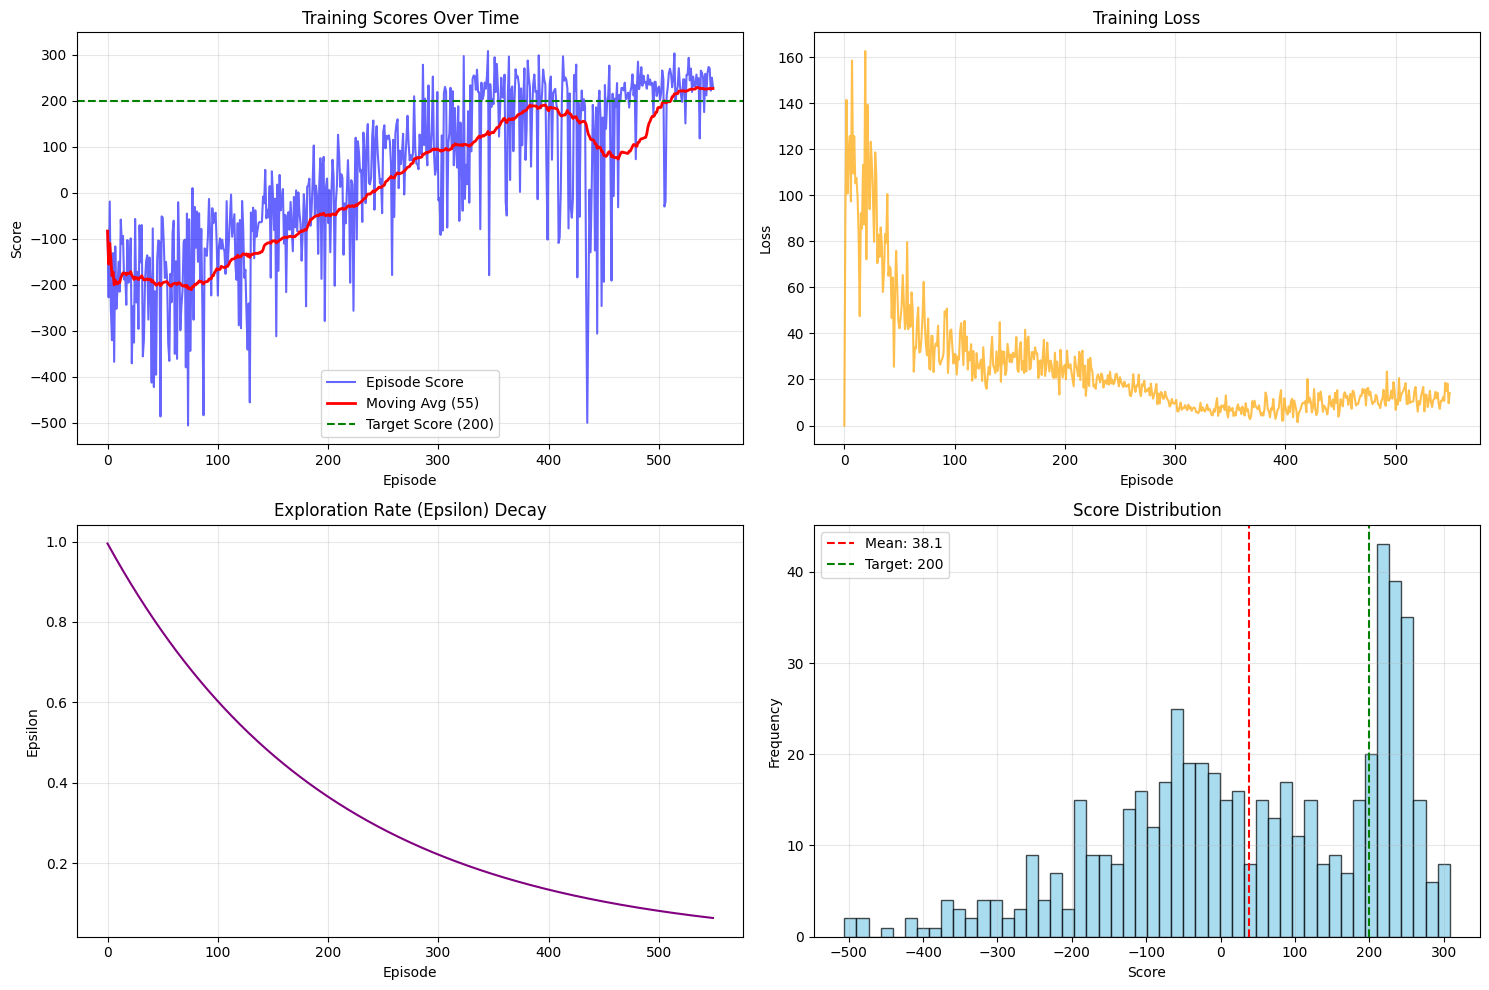


=== Training Summary ===
Total episodes: 550
Average score: 38.10
Best score: 308.06
Worst score: -505.98
Standard deviation: 179.29
Success rate (score >= 200): 28.9%
Last 100 episodes average: 210.39


In [10]:
# Plot training results
def plot_training_results(scores, losses, epsilons):
    """Plot comprehensive training results"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 5))
    
    # Plot 1: Episode scores
    ax1.plot(scores, alpha=0.6, color='blue', label='Episode Score')
    
    # Calculate moving average
    window = min(100, len(scores) // 10)
    if len(scores) >= window:
        moving_avg = []
        for i in range(len(scores)):
            start_idx = max(0, i - window + 1)
            moving_avg.append(np.mean(scores[start_idx:i+1]))
        ax1.plot(moving_avg, color='red', linewidth=2, label=f'Moving Avg ({window})')
    
    ax1.axhline(y=200, color='green', linestyle='--', label='Target Score (200)')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Score')
    ax1.set_title('Training Scores Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Training loss
    if len(losses) > 0:
        ax2.plot(losses, color='orange', alpha=0.7)
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Loss')
        ax2.set_title('Training Loss')
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Epsilon decay
    ax3.plot(epsilons, color='purple')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Epsilon')
    ax3.set_title('Exploration Rate (Epsilon) Decay')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Score distribution
    ax4.hist(scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax4.axvline(np.mean(scores), color='red', linestyle='--', label=f'Mean: {np.mean(scores):.1f}')
    ax4.axvline(200, color='green', linestyle='--', label='Target: 200')
    ax4.set_xlabel('Score')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Score Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Training Summary ===")
    print(f"Total episodes: {len(scores)}")
    print(f"Average score: {np.mean(scores):.2f}")
    print(f"Best score: {np.max(scores):.2f}")
    print(f"Worst score: {np.min(scores):.2f}")
    print(f"Standard deviation: {np.std(scores):.2f}")
    
    # Success rate (scores >= 200)
    success_rate = np.mean(np.array(scores) >= 200) * 100
    print(f"Success rate (score >= 200): {success_rate:.1f}%")
    
    # Last 100 episodes average
    if len(scores) >= 100:
        last_100_avg = np.mean(scores[-100:])
        print(f"Last 100 episodes average: {last_100_avg:.2f}")

# Plot results
plot_training_results(scores, losses, epsilons)

## 6. Testing the Trained Agent

In [11]:
# Test the trained agent
def test_agent(env, agent, n_episodes=10, render=True):
    """Test the trained agent"""
    
    test_scores = []
    test_episodes = []
    
    print(f"Testing agent for {n_episodes} episodes...")
    
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        frames = []
        steps = 0
        
        while True:
            # Choose action (no exploration)
            action = agent.act(state, training=False)
            
            # Take action
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            steps += 1
            
            if render and episode < 3:  # Only render first 3 episodes
                frames.append(env.render())
            
            if terminated or truncated:
                break
        
        test_scores.append(total_reward)
        print(f"Episode {episode + 1}: Score = {total_reward:.2f}, Steps = {steps}")
        
        # Store episode data for visualization
        if episode < 3:
            test_episodes.append({
                'episode': episode + 1,
                'score': total_reward,
                'steps': steps,
                'frames': frames
            })
    
    print(f"\n=== Test Results ===")
    print(f"Average score: {np.mean(test_scores):.2f}")
    print(f"Best score: {np.max(test_scores):.2f}")
    print(f"Worst score: {np.min(test_scores):.2f}")
    print(f"Success rate: {np.mean(np.array(test_scores) >= 200) * 100:.1f}%")
    
    return test_scores, test_episodes

# Test the agent
test_scores, test_episodes = test_agent(env, agent, n_episodes=10)

Testing agent for 10 episodes...
Episode 1: Score = 257.64, Steps = 312
Episode 2: Score = 78.18, Steps = 1000
Episode 3: Score = 253.18, Steps = 369
Episode 4: Score = 279.25, Steps = 405
Episode 5: Score = 224.44, Steps = 310
Episode 6: Score = 209.24, Steps = 319
Episode 7: Score = 223.87, Steps = 313
Episode 8: Score = 266.02, Steps = 345
Episode 9: Score = 269.41, Steps = 305
Episode 10: Score = 232.81, Steps = 307

=== Test Results ===
Average score: 229.40
Best score: 279.25
Worst score: 78.18
Success rate: 90.0%


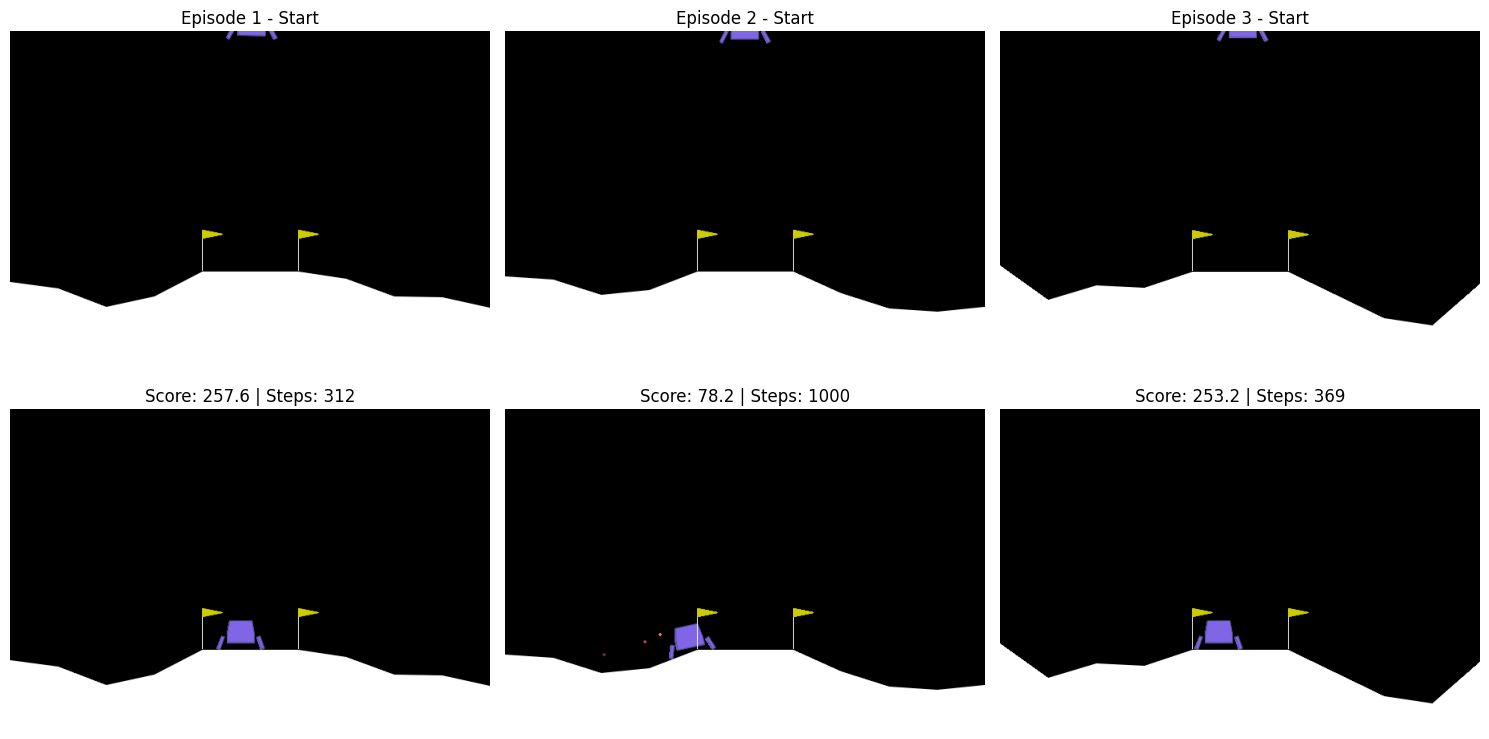

In [12]:
# Visualize test episodes
def visualize_test_episodes(test_episodes):
    """Visualize the first few test episodes"""
    
    n_episodes = len(test_episodes)
    fig, axes = plt.subplots(2, n_episodes, figsize=(5 * n_episodes, 8))
    
    if n_episodes == 1:
        axes = axes.reshape(-1, 1)
    
    for i, episode_data in enumerate(test_episodes):
        frames = episode_data['frames']
        
        if len(frames) > 0:
            # Show initial state
            axes[0, i].imshow(frames[0])
            axes[0, i].set_title(f"Episode {episode_data['episode']} - Start")
            axes[0, i].axis('off')
            
            # Show final state
            axes[1, i].imshow(frames[-1])
            axes[1, i].set_title(f"Score: {episode_data['score']:.1f} | Steps: {episode_data['steps']}")
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize test episodes
visualize_test_episodes(test_episodes)

## 7. Hyperparameter Analysis and Comparison

In [13]:
# Compare different hyperparameters
def compare_hyperparameters(env, configs, n_episodes=500):
    """Compare different hyperparameter configurations"""
    
    results = {}
    
    for name, config in configs.items():
        print(f"\n=== Testing configuration: {name} ===")
        print(f"Config: {config}")
        
        # Create agent with config
        agent = DQNAgent(
            state_size=state_size,
            action_size=action_size,
            **config
        )
        
        # Train agent
        scores, losses, epsilons = train_dqn_agent(
            env, agent,
            n_episodes=n_episodes,
            print_every=100,
            save_model=False
        )
        
        # Store results
        results[name] = {
            'scores': scores,
            'losses': losses,
            'epsilons': epsilons,
            'avg_score': np.mean(scores[-100:]),  # Last 100 episodes
            'success_rate': np.mean(np.array(scores[-100:]) >= 200) * 100
        }
    
    return results

# Define configurations to compare
configs = {
    'Default': {
        'lr': 0.0005,
        'gamma': 0.99,
        'epsilon_decay': 0.995
    },
    'Higher LR': {
        'lr': 0.001,
        'gamma': 0.99,
        'epsilon_decay': 0.995
    },
    'Lower Gamma': {
        'lr': 0.0005,
        'gamma': 0.95,
        'epsilon_decay': 0.995
    },
    'Faster Decay': {
        'lr': 0.0005,
        'gamma': 0.99,
        'epsilon_decay': 0.99
    }
}

print("Hyperparameter comparison configurations ready!")
print("Note: Running full comparison would take significant time.")
print("Uncomment the line below to run comparison:")
# results = compare_hyperparameters(env, configs, n_episodes=300)

Hyperparameter comparison configurations ready!
Note: Running full comparison would take significant time.
Uncomment the line below to run comparison:


## 8. Advanced Techniques and Improvements

In [14]:
# Double DQN implementation
class DoubleDQNAgent(DQNAgent):
    """Double DQN Agent - reduces overestimation bias"""
    
    def learn(self):
        """Train using Double DQN update rule"""
        if len(self.replay_buffer) < self.batch_size:
            return
        
        # Sample batch
        experiences = self.replay_buffer.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor([e.state for e in experiences]).to(self.device)
        actions = torch.LongTensor([e.action for e in experiences]).to(self.device)
        rewards = torch.FloatTensor([e.reward for e in experiences]).to(self.device)
        next_states = torch.FloatTensor([e.next_state for e in experiences]).to(self.device)
        dones = torch.BoolTensor([e.done for e in experiences]).to(self.device)
        
        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Double DQN: Use main network to select actions, target network to evaluate
        next_actions = self.q_network(next_states).argmax(1).unsqueeze(1)
        next_q_values = self.target_network(next_states).gather(1, next_actions).squeeze(1).detach()
        target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # Compute loss
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

print("Double DQN agent implemented!")

Double DQN agent implemented!


In [15]:
# Prioritized Experience Replay Buffer
class PrioritizedReplayBuffer:
    """Prioritized Experience Replay Buffer"""
    
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.max_priority = 1.0
    
    def push(self, state, action, reward, next_state, done):
        """Add experience with maximum priority"""
        experience = Experience(state, action, reward, next_state, done)
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience
        
        self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        """Sample batch with priorities"""
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.position]
        
        # Calculate sampling probabilities
        probs = prios ** self.alpha
        probs /= probs.sum()
        
        # Sample indices
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        
        # Calculate importance sampling weights
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        
        experiences = [self.buffer[idx] for idx in indices]
        
        return experiences, indices, weights
    
    def update_priorities(self, indices, priorities):
        """Update priorities for sampled experiences"""
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)
    
    def __len__(self):
        return len(self.buffer)

print("Prioritized Experience Replay implemented!")

Prioritized Experience Replay implemented!


## 9. Performance Analysis and Insights

=== Agent Behavior Analysis ===


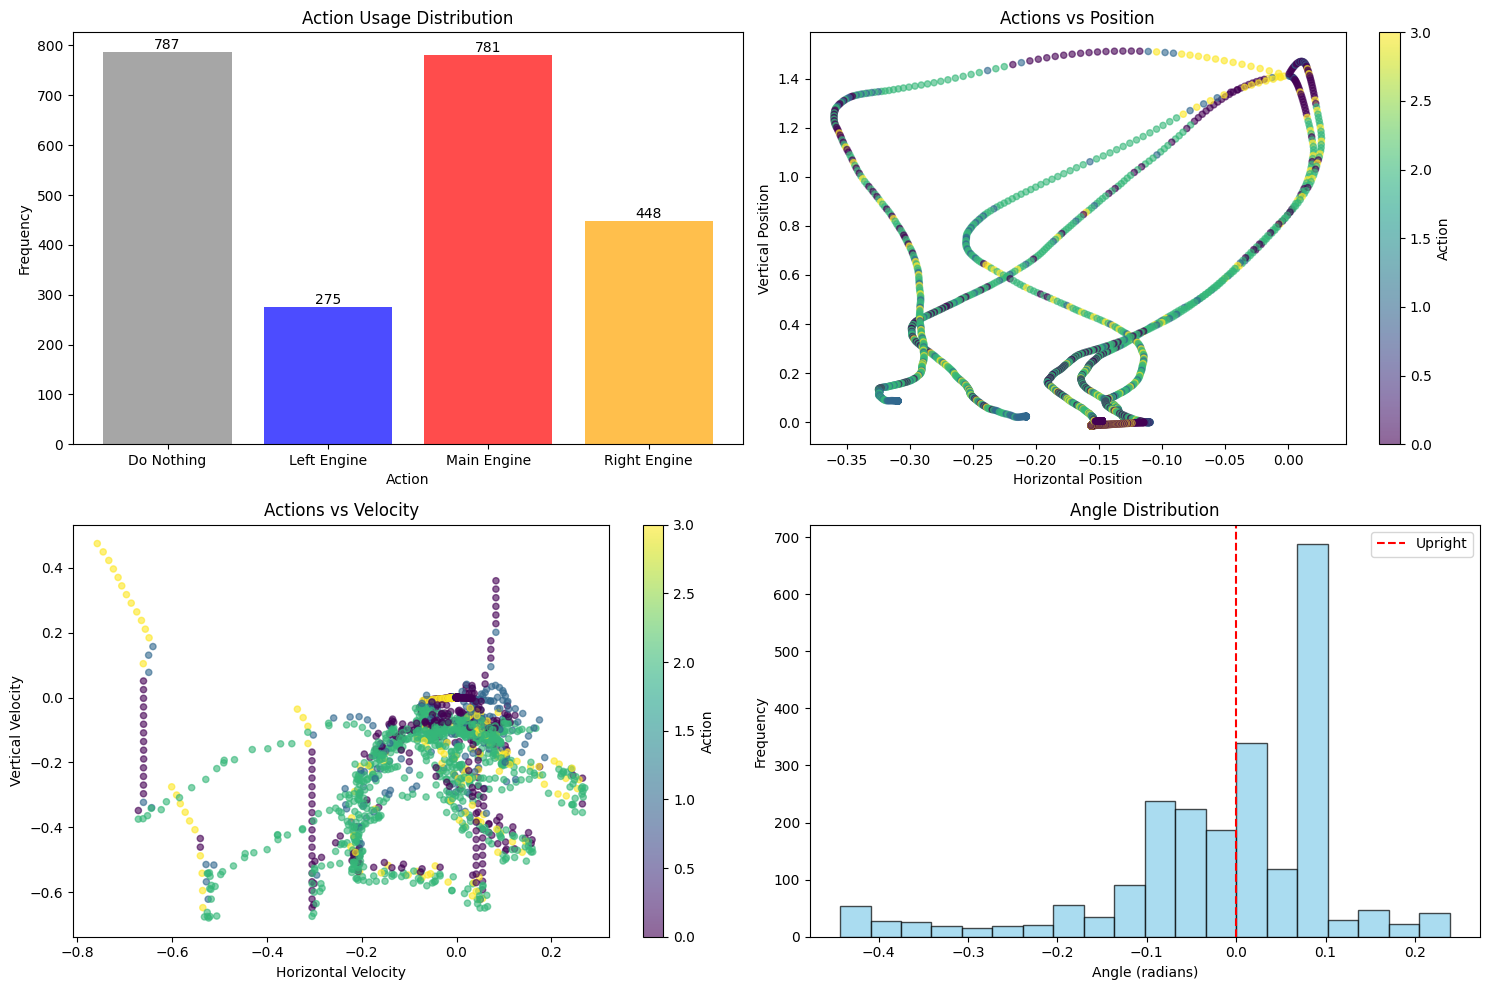


=== Insights ===
Total actions analyzed: 2291
Most used action: 0 (34.4%)
Average angle: -0.009 radians
Angle standard deviation: 0.131 radians


In [16]:
# Analyze agent performance
def analyze_agent_behavior(env, agent, n_episodes=5):
    """Analyze agent's decision making and behavior patterns"""
    
    print("=== Agent Behavior Analysis ===")
    
    action_counts = {i: 0 for i in range(4)}
    state_action_data = []
    
    for episode in range(n_episodes):
        state, _ = env.reset()
        episode_data = []
        
        while True:
            action = agent.act(state, training=False)
            action_counts[action] += 1
            
            # Store state-action data
            episode_data.append({
                'state': state.copy(),
                'action': action,
                'position': (state[0], state[1]),
                'velocity': (state[2], state[3]),
                'angle': state[4],
                'legs_contact': (state[6], state[7])
            })
            
            state, reward, terminated, truncated, _ = env.step(action)
            
            if terminated or truncated:
                break
        
        state_action_data.extend(episode_data)
    
    # Plot action distribution
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 5))
    
    # Action frequency
    actions = list(action_counts.keys())
    counts = list(action_counts.values())
    colors = ['gray', 'blue', 'red', 'orange']
    
    bars = ax1.bar(actions, counts, color=colors, alpha=0.7)
    ax1.set_xlabel('Action')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Action Usage Distribution')
    ax1.set_xticks(actions)
    ax1.set_xticklabels(['Do Nothing', 'Left Engine', 'Main Engine', 'Right Engine'])
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{count}', ha='center', va='bottom')
    
    # State analysis
    positions = [data['position'] for data in state_action_data]
    actions_taken = [data['action'] for data in state_action_data]
    
    # Position vs action
    x_positions = [pos[0] for pos in positions]
    y_positions = [pos[1] for pos in positions]
    
    scatter = ax2.scatter(x_positions, y_positions, c=actions_taken, 
                         cmap='viridis', alpha=0.6, s=20)
    ax2.set_xlabel('Horizontal Position')
    ax2.set_ylabel('Vertical Position')
    ax2.set_title('Actions vs Position')
    plt.colorbar(scatter, ax=ax2, label='Action')
    
    # Velocity analysis
    velocities = [data['velocity'] for data in state_action_data]
    x_velocities = [vel[0] for vel in velocities]
    y_velocities = [vel[1] for vel in velocities]
    
    scatter2 = ax3.scatter(x_velocities, y_velocities, c=actions_taken,
                          cmap='viridis', alpha=0.6, s=20)
    ax3.set_xlabel('Horizontal Velocity')
    ax3.set_ylabel('Vertical Velocity')
    ax3.set_title('Actions vs Velocity')
    plt.colorbar(scatter2, ax=ax3, label='Action')
    
    # Angle analysis
    angles = [data['angle'] for data in state_action_data]
    ax4.hist(angles, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax4.set_xlabel('Angle (radians)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Angle Distribution')
    ax4.axvline(0, color='red', linestyle='--', label='Upright')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    total_actions = sum(action_counts.values())
    print(f"\n=== Insights ===")
    print(f"Total actions analyzed: {total_actions}")
    print(f"Most used action: {max(action_counts, key=action_counts.get)} "
          f"({action_counts[max(action_counts, key=action_counts.get)]/total_actions*100:.1f}%)")
    print(f"Average angle: {np.mean(angles):.3f} radians")
    print(f"Angle standard deviation: {np.std(angles):.3f} radians")

# Analyze the trained agent
analyze_agent_behavior(env, agent, n_episodes=5)

## 10. Key Takeaways and Conclusion

### What We've Learned

1. **Environment Understanding**: The Lunar Lander environment provides a challenging continuous control problem with sparse rewards

2. **DQN Implementation**: We successfully implemented a Deep Q-Network with:
   - Experience replay for stable learning
   - Target network for reduced correlation
   - Epsilon-greedy exploration strategy

3. **Training Dynamics**: 
   - Initial random exploration with high epsilon
   - Gradual improvement as the agent learns
   - Importance of hyperparameter tuning

4. **Performance Analysis**: Successful agents learn to:
   - Control orientation with side engines
   - Use main engine for controlled descent
   - Balance fuel efficiency with safety

### Advanced Techniques Covered
- Double DQN for reduced overestimation
- Prioritized Experience Replay for better sample efficiency
- Comprehensive performance analysis

### Next Steps
- Try other RL algorithms (PPO, A3C, SAC)
- Experiment with different network architectures
- Apply techniques to other environments
- Implement multi-agent scenarios

In [17]:
# Save final model and create summary
def create_training_summary(scores, losses, epsilons):
    """Create comprehensive training summary"""
    
    summary = {
        'total_episodes': len(scores),
        'final_average_score': np.mean(scores[-100:]) if len(scores) >= 100 else np.mean(scores),
        'best_score': np.max(scores),
        'worst_score': np.min(scores),
        'success_rate': np.mean(np.array(scores) >= 200) * 100,
        'episodes_to_solve': None,
        'final_epsilon': epsilons[-1] if epsilons else None
    }
    
    # Find when environment was "solved" (avg score >= 200 for 100 episodes)
    if len(scores) >= 100:
        for i in range(100, len(scores) + 1):
            if np.mean(scores[i-100:i]) >= 200:
                summary['episodes_to_solve'] = i
                break
    
    print("\n" + "="*50)
    print("           LUNAR LANDER TRAINING SUMMARY")
    print("="*50)
    print(f"📊 Total Episodes Trained: {summary['total_episodes']}")
    print(f"🎯 Final Average Score: {summary['final_average_score']:.2f}")
    print(f"🏆 Best Score Achieved: {summary['best_score']:.2f}")
    print(f"💥 Worst Score: {summary['worst_score']:.2f}")
    print(f"✅ Success Rate (≥200): {summary['success_rate']:.1f}%")
    
    if summary['episodes_to_solve']:
        print(f"🎉 Environment Solved in: {summary['episodes_to_solve']} episodes")
    else:
        print(f"❌ Environment not yet solved (need avg ≥200 for 100 episodes)")
    
    if summary['final_epsilon']:
        print(f"🔍 Final Exploration Rate: {summary['final_epsilon']:.4f}")
    
    print("="*50)
    
    return summary

# Create final summary
final_summary = create_training_summary(scores, losses, epsilons)

# Clean up
env.close()
print("\n🚀 Lunar Lander RL training complete!")


           LUNAR LANDER TRAINING SUMMARY
📊 Total Episodes Trained: 550
🎯 Final Average Score: 210.39
🏆 Best Score Achieved: 308.06
💥 Worst Score: -505.98
✅ Success Rate (≥200): 28.9%
🎉 Environment Solved in: 545 episodes
🔍 Final Exploration Rate: 0.0635

🚀 Lunar Lander RL training complete!
